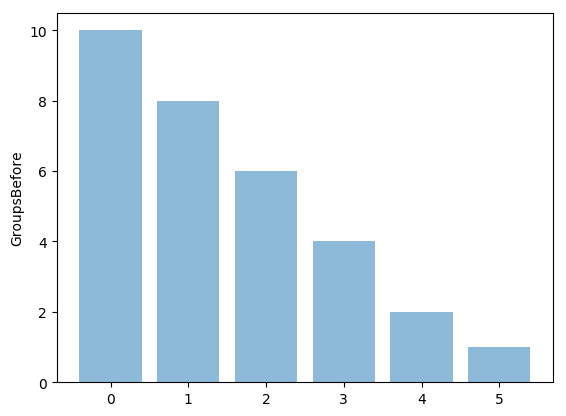

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = (0, 1, 2, 3, 4, 5)
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('GroupsBefore')
 
plt.show()